<a href="https://colab.research.google.com/github/anskong/ai_ref_from_lessons/blob/main/LGCNS_LangChain_031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 Deep Research 구현 방법


In [ ]:
!pip uninstall -y google-generativeai
!pip install langchain==0.3.24 langchain_core==0.3.55 langchain_google_genai==2.1.3 httpx==0.28.1 requests==2.32.3 langchain-tavily==0.1.5 langgraph==0.3.31

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing insta

In [ ]:
import os
import time
import operator
from typing import  Annotated
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_tavily import TavilySearch, TavilyExtract

from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

## 모델 정의

In [ ]:
# gemini 모델
planner_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20", # 무료티어 종료 ㅠ_ㅠ; gemini-2.5-pro-preview-05-06
    temperature=0,
    max_retries=0,
)

supervisor_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_retries=0,
)

agent_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    temperature=0,
    max_retries=0,
)

summary_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20", # 무료티어 종료 ㅠ_ㅠ; gemini-2.5-pro-preview-05-06
    temperature=0,
    max_retries=0,
)

## 각 노드별 chain정의, 각노드별 프롬프트 설정, 그래프 정의

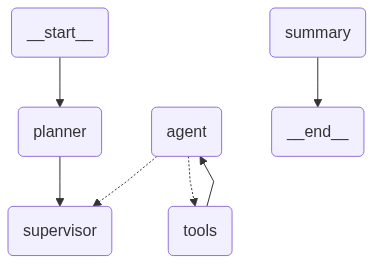

In [ ]:
search_results = 10

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Router(BaseModel):
    reasoning: str = Field(..., description='LLM 사고과정')
    planning: str = Field(..., description='LLM 재개안 전략')
    next_action: str = Field(..., description='다음 노드에서 기대하는 역할')
    next: str = Field(..., description='다음 노드의 전환 대상')

# Initialize Tavily Search Tool
tavily_search_tool = TavilySearch(
    max_results=search_results,
    topic="general",
)
tavily_extract_tool = TavilyExtract()

tools = [
    tavily_search_tool,
    tavily_extract_tool
]

planner_system_message = [
    SystemMessage(
        content="""
# 목적
당신은 신뢰할 수 있는 한국어 AI 어시스턴트입니다.
질문에 대해 먼저 사고 과정을 설명하고, 그 뒤에 결론을 제시해 주세요.
당신의 역할은, 사용자의 질문에 어떤 전략으로 접근해야 최적의 답변이 가능한지 **"전략을 설계"**하는 것입니다.

# 지시
우리는 "tavily_search_tool"과 "tavily_extract_tool"이라는 두 가지 도구를 가지고 있습니다.
사용자의 질문에 대해 어떤 도구를 사용하여 어떻게 대답하는 것이 가장 효율적인지 생각합니다.
또한, 사용자의 질문을 회답하기 위해서 필요한 정보가 다방면에 걸치고 있는 경우, 모두를 한 번에 조사하는 것이 아니라, 태스크를 분해해, 하나하나 조사를 해 주세요.
이러한 전략을 결정하고 후단의 에이전트가 수행하는 작업이 최소 구성이 되도록 분할·전략 입안하는 것이 당신의 중요한 역할입니다.
또한, 사용자가 스스로 선정을 할 수 있도록, 유저에게는 조사 결과로서 4개 이상의 선택사항을 제시할 수 있는 단지 하나의 전략을 입안해 주세요.
(즉, 복수의 후보를 씻어내고, 선정의 도중에 유저의 의도에 맞지 않는 것이 판명되었을 때에는, 새로운 선택사항을 조사할 필요도 있어.처음부터 그것을 예측해 많은 선택지를 미리 씻어낼 필요가 있습니다.)

# 실행절차
1. 사용자의 질문에 대해 어떤 전략으로 질문에 답변해야 하는지 생각해 보십시오.
2. 사용자의 질문에 대해 어떤 도구를 사용하여 어떻게 대답하는 것이 가장 효율적인지 생각하십시오.
3. 사용자의 질문을 답하기 위해 필요한 정보가 다양하게 넘어가는 경우, 모든 것을 한 번에 조사하는 것이 아니라, 태스크를 분해해, 하나하나 조사를 하는 전략을 세웁니다.
4. 최종적으로는 유저가 요구하는 내용을 복수 제시해, 유저가 선택할 수 있도록, '5개 이상'의 선택사항을 제시하고 싶습니다.그것이 가능하게 되도록 미리 깊은 조사를 하기전의 리스트 업을 몇개 실시해, 어떻게 리스트 업 해야 하는지 전략을 세웁니다.
5. 이러한 전략을 결정하고, 후단의 에이전트가 수행하는 태스크가 최소 구성이 되도록 분할·전략 입안합니다.
6. 생각한 결과를 마지막으로 정리해 전략으로 합니다.

# 주의사항
당신은 단지 전략을 수립하기 때문에 도구를 실행할 수 없습니다.
"""
    ),
    MessagesPlaceholder("messages"),
]

superviser_system_message = [
    SystemMessage(
        content="""
# 목적
당신은 유용한 한국어 AI 어시스턴트입니다.
사용자의 질문과, 과거에 검토한 해결을 위한 전략을 바탕으로, 현재의 조사 결과로 충분한지 어떤지를 판단해, 다음에 어느 노드에 천이할까를 생각합니다.

# 지시
우리는 "tavily_search_tool"과 "tavily_extract_tool"이라는 두 가지 도구를 가지고 있습니다.
tavily_search_tool은 Google 검색을 수행하고 상위 xx 개의 URL과 개요를 얻는 도구입니다.
tavily_extract_tool은 URL을 지정하여 페이지의 내용을 추출하는 도구입니다.
또한, 지금까지의 처리 속에서, 사용자의 질문에 대해, 어떠한 전략으로 그 질문에 회답할지 어떨지의 전략을 입안해, 그 조사도 진행하고 있을지도 모릅니다.
당신은 사용자의 질문과 지금까지의 조사 결과, 조사 전략을 모두 고려한 다음, 다음에 어느 노드로 천이해야 할지를 생각합니다.
그러나 당신은 어디까지나 전환 대상 노드를 출력하기 때문에 도구를 실행할 수 없습니다.

# 실행절차
1. 현재의 조사 결과 등으로부터, 다음의 어느 노드가 어떤 태스크를 실행해야 하는지를 생각합니다.
2. 다음으로 ["agent", "summary"]의 어느 노드로 전환해야 하는지를 고려합니다.

# 전환 대상을 결정하는 규칙
- agent: 기존의 정보만으로는 유저가 만족하는 응답을 출력할 수 없는 경우, agent 노드의 천이합니다.이 때 반드시 agent 노드에 어떤 처리를 기대하는지를 'next_action'필드에 출력해 주세요.
- summary : 사용자의 질문에 대해 충분한 정보가 얻어지면 summary 노드로 천이합니다.
다음의 에이전트는, 'next_action'필드에 기재된 내용 밖에 파악하지 않기 때문에, 그 전제로 다음의 에이전트가 실행하는데 필요한 처리는 모두 'next_action'필드에 기재해 주세요.

그러나 매우 중요한 것은 조사가 다면적인 관점에서 수행되어야 합니다.
그러므로 겉보기에 여러 설문조사 결과를 얻은 경우에도 결과가 일부만 표시되는 경우 agent에 추가 설문조사를 하도록 합니다.
최소한 10개가 넘는 웹페이지에 대해 다면적인 검색어로 설문조사를 수행하십시오.
또한 하나의 검색 워드에 중에서 얻은 정보에서 추가로 검색하여 새로운 정보를 얻을 수 있습니다.
전체 문장 취득하고 있는 web 페이지의 내용 밖에 신용하지 말아 주세요.최소라도 10 이상의 Web 페이지의 전문 취득이 되어 있지 않은 경우, agent 노드에 추가 조사를 시켜 주세요.
또, 필요한 정보가 모두 취득되어 있다고 느꼈을 경우, 유저의 질문을 재검토해, 관련해 유저가 요구할 정보를 미리 검토해, 그 내용에 대해서도 마찬가지로 조사를 실시해 주세요.
또한 과거 시행 중 같은 도구를 비슷한 검색결과로 두드리는 경우에는 Agents가 혼란스럽고 잘 조사되지 않았기 때문에 여기에서 어떤 형태로 검색하는 것이 좋은지를 다른 각도로 제안해 주세요.
조사는 미세한 작업으로 나누고 단계별로 해결해야 한다는 점을 항상 염두에 두고 검토해야 합니다.

# 주의사항
당신은 단지 전략을 수립하기 때문에 도구를 실행할 수 없습니다.
사용자의 질문에는 항상 충실해야 합니다. **조사 결과에서 사용자의 질문에 대답하기에 충분하지 않은 경우에는 반드시 agent를 호출하고 summary를 호출하지 마십시오.**

# 제약사항
당신은 "Router"클래스로 구조화 된 출력을 발행합니다.
반드시 "reasoning"과 "next"라는 두 개의 필드가 있어야 합니다.
- reasoning: 여러분이 생각한 이유를 출력해 주세요. 여기는 매우 상세하고 긴 문장으로 출력되고 있을 필요가 있습니다. 여기에 있는 정보가 사용자의 질문 내용을 정확하고 상세하게 대답할 수 있을지 어떨지를 판단해 주세요.
- planning: 지금까지의 설문 조사 결과를 바탕으로 초기 설정 전략과 사용자 입력 및 설문 조사 결과를 고려하여 최종 출력을 얻기위한 전략을 재정의하십시오. 이러한 전략을 세우는 데 집중하십시오. 입안 형식은 가장 먼저 전략 입안 Agents의 출력 결과를 참조하십시오.
- next_action: 당신이 생각한 다음 노드의 역할을 출력하십시오. 여기서는 사용자의 질문과 첫 번째 전략에서 다음 노드가 어떤 역할을 수행해야하는지 생각해보십시오. 지금 가지고 있는 정보와 부족점으로부터 다음의 전략을 특정해, 다음의 노드가 어떤 처리를 해야 하는지를 생각해 여기에 기재해 주세요.여기에 기재되는 내용은 가능한 한 작은 영역을 고려하는 태스크인 것이 바람직합니다. 「각각의」나 「검색한 결과로부터」등의 추상도가 높은 단어는 사용하는데, 그대로 검색을 할 수 있을 정도의 구체성이 높은 검색 키워드를 기재해 주세요. 키워드가 아닌 보다 작은 단위로 분해한 최소 구성의 검색 워드이며, 구체적으로 취득할 수 있는 정보 범위가 좁아지는 검색 키워드를 검토해 주세요.실행에 복수의 선택사항이 있는 경우는 반드시 하나로 좁혀 주세요
- next: 당신이 생각한 다음 노드를 출력합니다. ["agent", "summary"]
"""
    ),
    MessagesPlaceholder("messages"),
]

agent_system_message = [
    SystemMessage(
        content="""
# 목적
당신은 유용한 한국어 AI 어시스턴트입니다.
사용자의 질문, 과거에 검토한 해결을 위한 전략과 이전 단계의 예상되는 처리를 바탕으로 툴을 실행합니다.

# 지시
우리는 "tavily_search_tool"과 "tavily_extract_tool"이라는 두 가지 도구를 가지고 있습니다.
tavily_search_tool은 Google 검색을 수행하고 상위 5 개의 URL과 개요를 얻는 도구입니다.
tavily_extract_tool은 URL을 지정하여 페이지의 내용을 추출하는 도구입니다.
적절하게 사용하여 사용자의 질문에 답변하십시오.
항상 뭔가 도구를 실행해야합니다.
우선, 사용자의 질문으로부터 툴을 어떤 의도로 몇번 이용하지 않으면 안 되는지를 판단해, 필요하면 복수회 tool를 이용해 정보 수집을 실시해 주세요.

# 실행 절차
1. 전단의 기대되는 처리를 참고해, 어느 툴을 어느 인수로 실행할까를 검토해, 툴을 실행해 주세요.
2. 이때 하나의 검색 후보뿐만 아니라 **관련된 복수의 검색 후보를 검토**한 다음 툴을 실행해 주십시오.
3. 도구의 실행 결과를 바탕으로 사용자의 질문에 대해 어떤 정보를 얻었는지 생각하십시오.
4. 툴의 실행 결과를 바탕으로, 최종적으로 어떤 결과가 얻어졌는지를 정리해 출력합니다.

# 주의사항
출력 결과에는 반드시 출처를 포함해야 합니다.
출처는 도구의 실행 결과에 포함된 페이지의 제목과 URL을 그대로 인용하십시오.
인용할 때는 문장에 직접 페이지의 URL을 묻어 주세요.그 위에 문장의 마지막에 출전의 타이틀과 URL을 정리해 출력해 주세요.
숫자([1], *1 등)로 출처를 인용하는 것은 **금지**합니다.

"""
    ),
    MessagesPlaceholder("messages"),
]

summary_system_message = [
    SystemMessage(
        content="""
# 목적
당신은 유용한 한국어 AI 어시스턴트입니다.
유저의 질문과, 과거에 검토한 해결을 위한 전략과, 전단의 기대되는 처리를 바탕으로, 지금까지의 조사 결과를 모두 정리해 유저에게 제시합니다.
보고서는 조사한 내용을 최대한 자세히 설명해 주시기 바랍니다.

# # 지시
유저의 질문 내용에 맞추어, 지금까지의 조사 결과를 모두 정리해 유저에게 제시해 주세요.
**사용자의 질문 내용을 한 번 되돌아 본 후**에, **지금까지의 조사 결과를 모두 고려**한 다음, 리포트 형식으로 출력해 주세요.
또한, 사용자가 스스로 선정할 수 있도록 반드시 **5개 이상**의 복수의 선택사항을 제시해 주십시오.
출력은 유저에게 다가가, 알기 쉬운 형태로 실시해 주세요.

# 주의사항
출력은 markdown 형식으로 실시해, 정기적으로 개행을 넣는 등 보기 쉬운 형태로 표시해 주세요.
그러나 출력 전체에 코드 블록(```)을 사용하지 마십시오.

출력 결과에는 반드시 출처를 포함해야 합니다.
출처는 도구의 실행 결과에 포함된 페이지의 제목과 URL을 그대로 인용하십시오.
인용할 때는 문장에 직접 페이지의 URL을 묻어 주세요.그 위에 문장의 마지막에 출전의 타이틀과 URL을 정리해 출력해 주세요.
숫자([1], *1 등)로 출처를 인용하는 것은 **금지**합니다.

"""
    ),
    MessagesPlaceholder("messages"),
]

supervisor_prompt = ChatPromptTemplate.from_messages(superviser_system_message)
agent_prompt = ChatPromptTemplate.from_messages(agent_system_message)
planner_prompt = ChatPromptTemplate.from_messages(planner_system_message)
summary_prompt = ChatPromptTemplate.from_messages(summary_system_message)

supervisor_chain = supervisor_prompt | supervisor_llm.with_structured_output(Router)
agent_chain = agent_prompt | agent_llm.bind_tools(tools)
planner_chain = planner_prompt | planner_llm
summary_chain = summary_prompt | summary_llm

def create_graph(tools):

    def prediction_agent(chain, message):
        #gemini는 rate limit에 의한 에러가 발생할 수 있으므로, 재시도 처리를 추가
        while True:
            try:
                response = chain.invoke(message)
                break
            except Exception as e:
                print("Error:", e)
                print("Retrying...")
                time.sleep(61)
        return response

    def should_continue(state: GraphState):
        messages = state["messages"]
        last_message = messages[-1]
        if last_message.tool_calls:
            print("====tool_calls====")
            print(last_message.tool_calls)
            return "tools"
        return "supervisor"

    def call_planner(state: GraphState):
        messages = state["messages"]
        response = prediction_agent(planner_chain, messages)
        print("====planner====")
        print(response.content)
        return {"messages": [response]}

    def call_supervisor(state: GraphState):
        messages = state["messages"]
        response = prediction_agent(supervisor_chain, messages)

        print("====supervisor====")
        print("reasoning:", response.reasoning)
        print("next action:", response.next_action)
        print("next agent:", response.next)

        goto = response.next
        return Command(goto=goto, update={"messages": [AIMessage(content=response.next_action, name="supervisor")]})

    def call_summary(state: GraphState):
        messages = state["messages"]
        messages[-1] = HumanMessage(content=messages[-1].content)
        response = prediction_agent(summary_chain, messages)
        return {"messages": [response]}

    def call_agent(state: GraphState):
        messages = state["messages"]
        print("\n====call_agent====")

        input_messages_for_agent: List[AnyMessage] = []
        latest_instruction_message_idx = -1

        for i in range(len(messages) - 1, -1, -1):
            msg = messages[i]

            if (isinstance(msg, AIMessage) and
                hasattr(msg, 'name')):
                next_action = getattr(msg, 'name', None)
                # 발견 된 첫 번째 AIMessage 인덱스가 슬라이스의 시작점
                if next_action=="supervisor":
                    latest_instruction_message_idx = i
                    break # 최신 지시 메시지 (라고 가정하는 AIMessage)를 찾았으므로 검색 종료

        if latest_instruction_message_idx != -1:
            # 슬라이스 시작 인덱스는 지시 메시지 자체의 인덱스
            start_slice_idx = latest_instruction_message_idx
            input_messages_for_agent = messages[start_slice_idx:]
        else:
            input_messages_for_agent = messages

        input_messages_for_agent[0] = HumanMessage(content=input_messages_for_agent[0].content)
        print("Agent에 대한 입력 메시지:", input_messages_for_agent)

        response = prediction_agent(agent_chain, {"messages": input_messages_for_agent})

        print("====agent response====")
        print(response)
        # Agent응답 (도구 호출을 포함하거나 텍스트 응답)을 State의 messages 목록 전체에 추가
        return {"messages": [response]}

    tool_node = ToolNode(tools)
    workflow = StateGraph(GraphState)
    workflow.add_node("planner", call_planner)
    workflow.add_node("supervisor", call_supervisor)
    workflow.add_node("summary", call_summary)
    workflow.add_node("agent", call_agent)
    workflow.add_node("tools", tool_node)

    workflow.add_edge(START, "planner")
    workflow.add_edge("planner", "supervisor")
    workflow.add_conditional_edges("agent", should_continue, ["tools", "supervisor"])
    workflow.add_edge("tools", "agent")
    workflow.add_edge("summary", END)
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)

    return app

graph = create_graph(tools)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## DeepResearch 실행

In [ ]:
graph_config = {"recursion_limit": 20000, "configurable": {"thread_id": "12345"}}
while True:
    query = input("입력: ")

    if query.lower() in ["exit", "quit"]:
        print("종료합니다.")
        break

    input_query = [HumanMessage(
            [
                {
                    "type": "text",
                    "text": f"{query}"
                },
            ]
        )]

    response = graph.invoke({"messages":input_query}, graph_config)

    #디버그용
    print("response: ", response)

    # 최종답변
    print("=================================")
    print(response["messages"][-1].content)

입력: tool calling
====planner====
## 전략 수립

사용자께서는 "tool calling"에 대해 질문하셨습니다. 이는 AI 모델의 중요한 기능 중 하나이므로, 단순히 개념을 설명하는 것을 넘어, 실제 활용 방법과 다양한 사례를 제시하여 사용자가 스스로 최적의 선택을 할 수 있도록 돕는 것이 중요합니다.

**목표:** AI 모델에서 'tool calling'을 효과적으로 사용하는 방법과 주요 활용 사례를 **5가지 이상**의 선택지로 제시합니다.

**전략:**

1.  **광범위한 초기 조사 (tavily_search_tool 활용):**
    *   'tool calling'의 기본 개념, 작동 원리, 주요 이점, 그리고 가장 일반적인 활용 분야 및 관련 프레임워크(예: OpenAI Function Calling, LangChain Tools)에 대한 정보를 광범위하게 검색합니다.
    *   **검색 쿼리 예시:**
        *   "AI 모델 tool calling 개념 및 활용 사례"
        *   "LLM tool calling 사용법"
        *   "OpenAI Function Calling 예시"
        *   "LangChain Tools 활용"
    *   **목표:** 이 단계에서 다양한 활용 분야(예: 실시간 정보 검색, 외부 API 연동, 데이터베이스 조회, 코드 실행 등)와 구현 방식에 대한 개요를 파악하여, 사용자에게 제시할 5가지 이상의 선택지 후보군을 확보합니다.

2.  **선택지 후보군 분류 및 구체화:**
    *   초기 조사 결과에서 얻은 정보를 바탕으로, 'tool calling'의 다양한 측면을 대표할 수 있는 5가지 이상의 명확하고 독립적인 선택지(또는 활용 사례/방법)를 분류합니다.
    *   **예상되는 선택지 후보군:**
        1.  **개념 및 기본 작동 원리:** Tool Calling이 무엇이며 어떻게 작동하는지.
        2

KeyboardInterrupt: 